In [1]:
import sys
sys.path.append('/home/indujaa/work/research/venus/backscatter/pvert')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import pandas as pd
import geopandas as gpd
import fiona

from FresnelCoefficients import FresnelV, FresnelH

sys.path.append('/home/indujaa/work/research/venus/tessera/tessera_ovda_uafpc_wsl')
import RFE_model_fitting as RFE

In [2]:
### Regression function: Venus altitude vs temperature from 

def pradius2T(pradius):
    return (pradius - 6139.5 ) / -0.1192

def T2pradius(T):
    return (-0.1192 * T) + 6139.5

def curieweiss(Tc, T, C):
    ### Curie-Weiss equation
    eps = np.zeros_like(T)
    eps[T>Tc] = C / (T[T>Tc] - Tc) #**.7
    epsmax = np.nanmin(eps)
    eps[T<=Tc] = epsmax
    return eps

def RFE_santos_eiras(T, T_max, eps_max, delta, gamma=2):
    ### equation for relaxor ferroelectrics - Santos and Eiras
    eps = np.zeros_like(T)
    eps = eps_max / (1 + np.abs(np.power((T - T_max).astype(np.complex)/delta,gamma)))
    return eps


### Equations for emissivity and reflectivity:

def eps2ref(eps):
    rh, th, Rh, Th = FresnelH(1, eps, np.deg2rad(35))
    return Rh
    
def eps2emis(eps):
    rh, th, Rh, Th = FresnelH(1, eps, np.deg2rad(35))
    return 1 - Rh

### dielectric mixing
def effective_permittivy_sphere(eps_eff, eps, eps_inc, f, N):
    # eps_eff = eps + ((3 * f * (eps_inc - eps) * eps_eff) / (3 * eps_eff + (eps_inc - eps_eff)* (1-f)))
    eps_eff_final = 0
    sum_term = 0
    
    for i in N:
        sum_term =  eps_eff / (eps_eff + i * (eps_inc - eps_eff)) 
        
    eps_eff = eps + ((f/3) * (eps_inc - eps) *  sum_term)
    return eps_eff

## get volume of ferroelectrics
def volume_FE(eps_inc, eps_eff = 65, eps_bg = 3.5, N = [1/2, 1/2, 0]):
    sum_term = 0
    for i in N:
        sum_term =  eps_eff / (eps_eff + i * (eps_inc - eps_eff)) 
        
    f = 3 * (eps_eff - eps_bg) / (eps_inc - eps_bg) / sum_term
    return f

# return geodataframe from file
def get_df(file, unit, emissivity_field = "SURFACE_EMISSIVITY", topo_field = "AVERAGE_PLANETARY_RADIUS"):
    data = gpd.read_file(file, layer=unit)
    data = data[data[emissivity_field]<1]
    return data

### <b> PLOT BEST-FIT FE AND RFE MODELS ALONG WITH DATA </b>

In [3]:
file = ("/home/indujaa/work/research/venus/tessera/ImpactDeposits_uafpc/Datasets/Ovda/Final/gpkg_units/arcdr_rdf_ovda_cycle1_Mar29_topoemis_hilosig2_n50_overlap05deg_n1deg_units_brushed_separate.gpkg")
allunits = fiona.listlayers(file)
units = ["Festoon flow", "3-a"]
colors = ["#ee8026", "#f4a736"]

# matplotlib.rcParams['font.sans-serif'] = "Arial"
# matplotlib.rcParams['font.family'] = "sans-serif"


emissivity_field = "SURFACE_EMISSIVITY"
topo_field = "AVERAGE_PLANETARY_RADIUS"

In [4]:
# best fit RFE parameters for festoon flow and 3-a
RFE_eps_max = [1e5, 1e5]
delta = [7,6]
gamma = [1.8, 1.8]
RFE_conc = [0.0015, 0.001]
RFE_Tm = [703.7717, 703.5881]

# best fit FE parameters for festoon flow and 3-a
FE_C = [1e5, 1e5]
FE_Tc = [702.2717, 700.0881]
FE_conc = [0.005, 0.005]

In [5]:
emisH = []
emisH_fe = []
e_range = []
temp_range = []

for i in range(2):
    data = get_df(file, units[i], emissivity_field, topo_field)

    emis_min_row = data.loc[data[emissivity_field] == data[emissivity_field].min()]
    # elev_range = np.arange(data[topo_field].min(), data[topo_field].max(), 1e-4)
    elev_range = np.arange(6052.5, data[topo_field].max(), 1e-4)
    e_range.append(elev_range)
    T_range = pradius2T(elev_range)
    temp_range.append(T_range)
    T_m = pradius2T(emis_min_row[topo_field].values[0])
    eps_bg = 5
    N = [1/2, 1/2, 0]

    ## RFE fitting metrics
    # T_m = 704.5956

    eps_max = RFE_eps_max[i]
    delta = 8
    gamma = 1.8
    f = RFE_conc[i]
    T_m = RFE_Tm[i]
    #T_m = 704.09

    eps_inc_rfe = RFE_santos_eiras(T_range, T_m, eps_max, delta, gamma)

    eps_eff_initial = 65
    eps_eff_final = np.zeros_like(eps_inc_rfe)
    for k in range(len(eps_inc_rfe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_rfe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final[k] = eps_eff
                break

    # emisH = eps2emis(eps_eff_final)
    emisH.append(eps2emis(eps_eff_final))


    ## FE fitting
    C = FE_C[i]
    T_m = FE_Tc[i]
    f = FE_conc[i]


    eps_inc_fe = curieweiss(T_m, T_range, C)
    eps_eff_final_fe = np.zeros(len(eps_inc_fe), dtype=float)


    for k in range(len(eps_inc_fe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_fe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final_fe[k] = eps_eff
                break

    # emisH_fe= eps2emis(eps_eff_final_fe)
    emisH_fe.append(eps2emis(eps_eff_final_fe))

AttributeError: module 'numpy' has no attribute 'complex'.
`np.complex` was a deprecated alias for the builtin `complex`. To avoid this error in existing code, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

IndexError: list index out of range

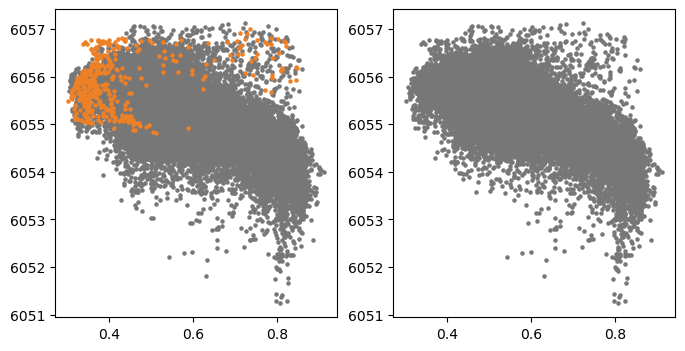

In [6]:
fig, ax = plt.subplots(1, 2, sharex=True)
# ax2 = ax.twinx()
fig.set_size_inches(8, 4)


for layername in allunits:
    data = gpd.read_file(file, layer=layername)
    if layername != "Festoon flow":
        ax[0].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#777777", s=5)
    if layername != "3-a":
        ax[1].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#777777", s=5)
        
for i in range(2):
    data = gpd.read_file(file, layer=units[i])
    data = data[data[emissivity_field]<1]
    ax[i].scatter(data[emissivity_field], data[topo_field], marker = 'o', s=5, color = colors[i])
    ax[i].plot(emisH[i], e_range[i], color = "k", linewidth = 1, label = "Santos and Eiras (2012)")
    ax[i].plot(emisH_fe[i][temp_range[i] > FE_Tc[i]], e_range[i][temp_range[i] > FE_Tc[i]], color = "k", linewidth = 1, linestyle = "--", label = "Shepard et al. (1994)")
    # 
    ax[i].set_xlim(0.15, 1.0)
    ax[i].set_ylim(6052, 6058)

    ax[i].set_xlabel("Emissivity", fontsize = 9)
    ax[i].set_ylabel("Planetary radius (km)", fontsize = 9)
    
    ax[i].tick_params(axis="both", which="major", labelsize=9)
    ax[i].legend(fontsize = 8, loc = "lower left")
    ax[i].xaxis.labelpad = 5
    ax[i].yaxis.labelpad = 5

    ## secondary y axis
    ax2 = ax[i].twinx()
    ax2.set_ylabel("Temperature (K)", fontsize = 9)
    ymin, ymax = ax[i].get_ylim()
    ax2.set_ylim(pradius2T(ymin),pradius2T(ymax))
    ax2.tick_params(axis="both", which="major", labelsize=9)
    ax2.yaxis.labelpad = 5
    
# ax[1].set_xlabel("Emissivity", fontsize = 9)
fig.tight_layout()
# plt.savefig("Fig9.pdf", bbox_inches='tight')
plt.show()

### <b> Revisions </b>

In [16]:
ffile = "/home/indujaa/work/research/venus/tessera/ImpactDeposits_uafpc/Datasets/Ovda/Final/gpkg_units/arcdr_rdf_ovda_cycle1_May20_topoemis_hilosig2_n50_overlap05deg_n1deg_units.gpkg"
bfile = "/home/indujaa/work/research/venus/tessera/ImpactDeposits_uafpc/Datasets/Ovda/Final/gpkg_units/brushed_unit_may20.gpkg"
files = [ffile, bfile]
units = ["Festoon flow", "rdf"]

In [17]:
colors=["#BB5566", "#DDAA33", "#004488"]
emissivity_field = "SURFACE_EMISSIVITY"
topo_field = "AVERAGE_PLANETARY_RADIUS"

In [20]:
#new oct 19

RFE_eps_max = [1e5, 1e5]
delta = [7,7]
gamma = [1.8, 1.8]
RFE_conc = [0.0015, 0.001]
RFE_Tm = [703.7717, 702.8754]

FE_C = [1e5, 1e5]
FE_Tc = [702.2717, 699.3754]
FE_conc = [0.005, 0.005]

In [21]:
emisH = []
emisH_fe = []
e_range = []
temp_range = []

for i in range(2):
    data = RFE.get_df(files[i], units[i], emissivity_field, topo_field)

    emis_min_row = data.loc[data[emissivity_field] == data[emissivity_field].min()]
    # elev_range = np.arange(data[topo_field].min(), data[topo_field].max(), 1e-4)
    elev_range = np.arange(6052.5, data[topo_field].max(), 1e-4)
    e_range.append(elev_range)
    T_range = pradius2T(elev_range)
    temp_range.append(T_range)
    T_m = pradius2T(emis_min_row[topo_field].values[0])
    eps_bg = 5
    N = [1/2, 1/2, 0]

    ## RFE fitting metrics
    # T_m = 704.5956

    eps_max = RFE_eps_max[i]
    delta = 8
    gamma = 1.8
    f = RFE_conc[i]
    T_m = RFE_Tm[i]
    #T_m = 704.09

    eps_inc_rfe = RFE.RFE_santos_eiras(T_range, T_m, eps_max, delta, gamma)

    eps_eff_initial = 65
    eps_eff_final = np.zeros_like(eps_inc_rfe)
    for k in range(len(eps_inc_rfe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_rfe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final[k] = eps_eff
                break

    # emisH = eps2emis(eps_eff_final)
    emisH.append(eps2emis(eps_eff_final))


    ## FE fitting
    C = FE_C[i]
    T_m = FE_Tc[i]
    f = FE_conc[i]


    eps_inc_fe = RFE.curieweiss(T_m, T_range, C)
    eps_eff_final_fe = np.zeros(len(eps_inc_fe), dtype=float)


    for k in range(len(eps_inc_fe)):
        eps_eff_initial = 65
        while True:
            eps_eff = effective_permittivy_sphere(eps_eff_initial, eps_bg, eps_inc_fe[k], f, N)
            temp = eps_eff_initial
            eps_eff_initial = eps_eff
            if (abs(temp - eps_eff_initial) <= 0.001):
                eps_eff_final_fe[k] = eps_eff
                break

    # emisH_fe= eps2emis(eps_eff_final_fe)
    emisH_fe.append(eps2emis(eps_eff_final_fe))

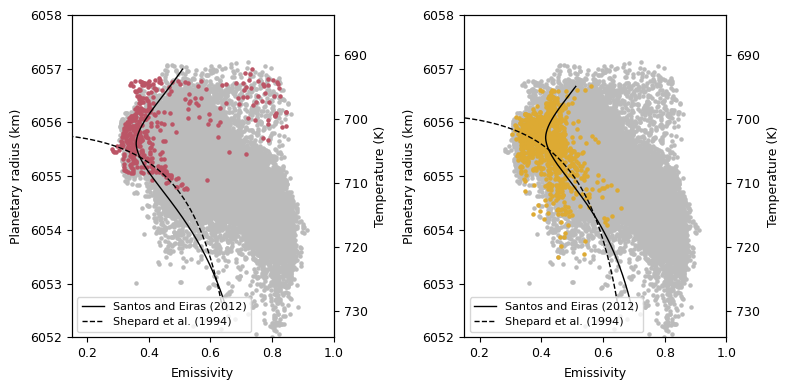

In [22]:
fig, ax = plt.subplots(1, 2, sharex=True)
# ax2 = ax.twinx()
fig.set_size_inches(8, 4)

file = ("/home/indujaa/work/research/venus/tessera/ImpactDeposits_uafpc/Datasets/Ovda/Final/gpkg_units/arcdr_rdf_ovda_cycle1_May20_topoemis_hilosig2_n50_overlap05deg_n1deg_units_brushed_separate.gpkg")
allunits = fiona.listlayers(file)

for layername in allunits:
    data = gpd.read_file(file, layer=layername)
    if layername != "Festoon flow":
        ax[0].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#bbbbbb", s=5)
    ax[1].scatter(data[emissivity_field], data[topo_field], marker = 'o', color="#bbbbbb", s=5)

        
for i in range(2):
    data = gpd.read_file(files[i], layer=units[i])
    data = data[data[emissivity_field]<1]
    ax[i].scatter(data[emissivity_field], data[topo_field], marker = 'o', s=5, color = colors[i])
    ax[i].plot(emisH[i], e_range[i], color = "k", linewidth = 1, label = "Santos and Eiras (2012)")
    ax[i].plot(emisH_fe[i][temp_range[i] > FE_Tc[i]], e_range[i][temp_range[i] > FE_Tc[i]], color = "k", linewidth = 1, linestyle = "--", label = "Shepard et al. (1994)")
    # 
    ax[i].set_xlim(0.15, 1.0)
    ax[i].set_ylim(6052, 6058)

    ax[i].set_xlabel("Emissivity", fontsize = 9)
    ax[i].set_ylabel("Planetary radius (km)", fontsize = 9)
    
    ax[i].tick_params(axis="both", which="major", labelsize=9)
    ax[i].legend(fontsize = 8, loc = "lower left")
    ax[i].xaxis.labelpad = 5
    ax[i].yaxis.labelpad = 5

    ## secondary y axis
    ax2 = ax[i].twinx()
    ax2.set_ylabel("Temperature (K)", fontsize = 9)
    ymin, ymax = ax[i].get_ylim()
    ax2.set_ylim(pradius2T(ymin),pradius2T(ymax))
    ax2.tick_params(axis="both", which="major", labelsize=9)
    ax2.yaxis.labelpad = 5
    
# ax[1].set_xlabel("Emissivity", fontsize = 9)
fig.tight_layout()
# plt.savefig("Fig9_oct15.png", bbox_inches='tight')
plt.show()